In [1]:
import os, sys, email,re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
import networkx as nx
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

In [2]:
emails_df = pd.read_csv('D:\emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [3]:
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [4]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
emails_df['content'] = list(map(get_text_from_email, messages))
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

file                                     Message-ID  \
0     allen-p/_sent_mail/1.  <18782981.1075855378110.JavaMail.evans@thyme>   
1    allen-p/_sent_mail/10.  <15464986.1075855378456.JavaMail.evans@thyme>   
2   allen-p/_sent_mail/100.  <24216240.1075855687451.JavaMail.evans@thyme>   
3  allen-p/_sent_mail/1000.  <13505866.1075863688222.JavaMail.evans@thyme>   
4  allen-p/_sent_mail/1001.  <30922949.1075863688243.JavaMail.evans@thyme>   

                                    Date                       From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  (phillip.allen@enron.com)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  (phillip.allen@enron.com)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  (phillip.allen@enron.com)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  (phillip.allen@enron.com)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  (phillip.allen@enron.com)   

                          To    Subject Mime-Version  \
0     (tim.belden@enron.com)                     1.0   
1  (john.lavorato@enron.com)        Re:          1.0   
2   (leah.arsdall@enron.com)   Re: test          1.0   
3    (randall.gay@enron.com)                     1.0   
4     (greg.piper@enron.com)  Re: Hello          1.0   

                   Content-Type Content-Transfer-Encoding           X-From  \
0  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
1  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
2  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
3  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
4  text/plain; charset=us-ascii                      7bit  Phillip K Allen   

                                                X-To X-cc X-bcc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>              
1  John J Lavorato <John J Lavorato/ENRON@enronXg...              
2                                   Leah Van Arsdall              
3                                      Randall L Gay              
4                                         Greg Piper              

                                            X-Folder X-Origin  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

                    X-FileName  \
0  pallen (Non-Privileged).pst   
1  pallen (Non-Privileged).pst   
2                   pallen.nsf   
3                   pallen.nsf   
4                   pallen.nsf   

                                             content     user  
0                          Here is our forecast\n\n   allen-p  
1  Traveling to have a business meeting takes the...  allen-p  
2                     test successful.  way to go!!!  allen-p  
3  Randy,\n\n Can you send me a schedule of the s...  allen-p  
4                Let's shoot for Tuesday at 11:45.    allen-p

In [5]:
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding','X-From','X-To','X-cc','X-bcc','X-Folder','X-Origin','X-FileName','user'], axis=1)
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

Date       object
From       object
To         object
Subject    object
content    object
dtype: object

In [6]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normalized

In [7]:
analysis_df=emails_df[['From', 'To', 'Date','Subject','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]

In [8]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [9]:
analysis_df.head()

From  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<15464986.1075855378456.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<24216240.1075855687451.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<13505866.1075863688222.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<30922949.1075863688243.JavaMail.evans@thyme>  (phillip.allen@enron.com)   

                                                                      To  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>     (tim.belden@enron.com)   
<15464986.1075855378456.JavaMail.evans@thyme>  (john.lavorato@enron.com)   
<24216240.1075855687451.JavaMail.evans@thyme>   (leah.arsdall@enron.com)   
<13505866.1075863688222.JavaMail.evans@thyme>    (randall.gay@enron.com)   
<30922949.1075863688243.JavaMail.evans@thyme>     (greg.piper@enron.com)   

                                                                    Date  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>  2001-05-14 16:39:00-07:00   
<15464986.1075855378456.JavaMail.evans@thyme>  2001-05-04 13:51:00-07:00   
<24216240.1075855687451.JavaMail.evans@thyme>  2000-10-18 03:00:00-07:00   
<13505866.1075863688222.JavaMail.evans@thyme>  2000-10-23 06:13:00-07:00   
<30922949.1075863688243.JavaMail.evans@thyme>  2000-08-31 05:07:00-07:00   

                                                 Subject  \
Message-ID                                                 
<18782981.1075855378110.JavaMail.evans@thyme>              
<15464986.1075855378456.JavaMail.evans@thyme>        Re:   
<24216240.1075855687451.JavaMail.evans@thyme>   Re: test   
<13505866.1075863688222.JavaMail.evans@thyme>              
<30922949.1075863688243.JavaMail.evans@thyme>  Re: Hello   

                                                                                         content  \
Message-ID                                                                                         
<18782981.1075855378110.JavaMail.evans@thyme>                          Here is our forecast\n\n    
<15464986.1075855378456.JavaMail.evans@thyme>  Traveling to have a business meeting takes the...   
<24216240.1075855687451.JavaMail.evans@thyme>                     test successful.  way to go!!!   
<13505866.1075863688222.JavaMail.evans@thyme>  Randy,\n\n Can you send me a schedule of the s...   
<30922949.1075863688243.JavaMail.evans@thyme>                Let's shoot for Tuesday at 11:45.     

                                                                                   clean_content  
Message-ID                                                                                        
<18782981.1075855378110.JavaMail.evans@thyme>                                           forecast  
<15464986.1075855378456.JavaMail.evans@thyme>  traveling business meeting takes fun trip espe...  
<24216240.1075855687451.JavaMail.evans@thyme>                             test successful way go  
<13505866.1075863688222.JavaMail.evans@thyme>  randy send schedule salary level everyone sche...  
<30922949.1075863688243.JavaMail.evans@thyme>                                  let shoot tuesday

In [10]:
analysis_df.drop('content',axis=1)

From  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<15464986.1075855378456.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<24216240.1075855687451.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<13505866.1075863688222.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<30922949.1075863688243.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
...                                                                  ...   
<26807948.1075842029936.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<25835861.1075842029959.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<28979867.1075842029988.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<22052556.1075842030013.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<28618979.1075842030037.JavaMail.evans@thyme>  (john.zufferli@enron.com)   

                                                                         To  \
Message-ID                                                                    
<18782981.1075855378110.JavaMail.evans@thyme>        (tim.belden@enron.com)   
<15464986.1075855378456.JavaMail.evans@thyme>     (john.lavorato@enron.com)   
<24216240.1075855687451.JavaMail.evans@thyme>      (leah.arsdall@enron.com)   
<13505866.1075863688222.JavaMail.evans@thyme>       (randall.gay@enron.com)   
<30922949.1075863688243.JavaMail.evans@thyme>        (greg.piper@enron.com)   
...                                                                     ...   
<26807948.1075842029936.JavaMail.evans@thyme>        (kori.loibl@enron.com)   
<25835861.1075842029959.JavaMail.evans@thyme>     (john.lavorato@enron.com)   
<28979867.1075842029988.JavaMail.evans@thyme>       (dawn.doucet@enron.com)   
<22052556.1075842030013.JavaMail.evans@thyme>      (jeanie.slone@enron.com)   
<28618979.1075842030037.JavaMail.evans@thyme>  (livia_zufferli@monitor.com)   

                                                                    Date  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>  2001-05-14 16:39:00-07:00   
<15464986.1075855378456.JavaMail.evans@thyme>  2001-05-04 13:51:00-07:00   
<24216240.1075855687451.JavaMail.evans@thyme>  2000-10-18 03:00:00-07:00   
<13505866.1075863688222.JavaMail.evans@thyme>  2000-10-23 06:13:00-07:00   
<30922949.1075863688243.JavaMail.evans@thyme>  2000-08-31 05:07:00-07:00   
...                                                                  ...   
<26807948.1075842029936.JavaMail.evans@thyme>  2001-11-28 13:30:11-08:00   
<25835861.1075842029959.JavaMail.evans@thyme>  2001-11-28 12:47:48-08:00   
<28979867.1075842029988.JavaMail.evans@thyme>  2001-11-28 07:20:00-08:00   
<22052556.1075842030013.JavaMail.evans@thyme>  2001-11-27 11:52:45-08:00   
<28618979.1075842030037.JavaMail.evans@thyme>  2001-11-26 10:48:43-08:00   

                                                                 Subject  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>                              
<15464986.1075855378456.JavaMail.evans@thyme>                        Re:   
<24216240.1075855687451.JavaMail.evans@thyme>                   Re: test   
<13505866.1075863688222.JavaMail.evans@thyme>                              
<30922949.1075863688243.JavaMail.evans@thyme>                  Re: Hello   
...                                                                  ...   
<26807948.1075842029936.JavaMail.evans@thyme>   Trade with John Lavorato   
<25835861.1075842029959.JavaMail.evans@thyme>                 Gas Hedges   
<28979867.1075842029988.JavaMail.evans@thyme>           RE: CONFIDENTIAL   
<22052556.1075842030013.JavaMail.evans@thyme>  Calgary Analyst/Associate   
<28618979.1075842030037.JavaMail.evans@thyme>           RE: ali's essays   

                                                                         

In [11]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [12]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [13]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

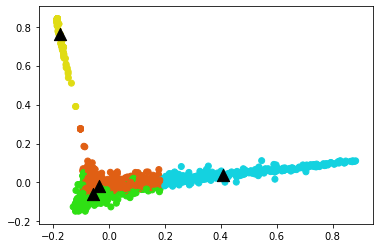

In [14]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [16]:
#vectoriztion of clean content 
dtm = cv.fit_transform(analysis_df.clean_content.values)

In [17]:
dtm

<354600x279897 sparse matrix of type '<class 'numpy.int64'>'
	with 28631673 stored elements in Compressed Sparse Row format>

In [18]:
#using LDA 
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=10,random_state=42)

In [ ]:
LDA.fit(dtm)

In [20]:
#printing out the top 15 words of each topic 
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['know', 'net', 'aol', 'recipient', 'cc', 'intended', 'mailto', 'pm', 'original', 'sent', 'mail', 'subject', 'message', 'enron', 'com']


THE TOP 15 WORDS FOR TOPIC #1
['type', 'schedule', 'alias', 'hour', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'schedules', 'pm', 'dbcaps', 'way', 'id', 'final', 'date', 'error', 'database', 'data']


THE TOP 15 WORDS FOR TOPIC #2
['management', 'services', 'www', 'http', 'companies', 'year', 'president', 'enron', 'energy', 'business', 'million', 'com', 'new', 'said', 'company']


THE TOP 15 WORDS FOR TOPIC #3
['need', 'sent', 'let', 'deal', 'forwarded', 'know', 'agreement', 'corp', 'thanks', 'pm', 'cc', 'subject', 'hou', 'enron', 'ect']


THE TOP 15 WORDS FOR TOPIC #4
['capacity', 'ferc', 'customers', 'new', 'prices', 'electricity', 'time', 'information', 'state', 'price', 'california', 'energy', 'gas', 'market', 'power']


THE TOP 15 WORDS FOR TOPIC #5
['jeff', 'forwarded', 'et', 'p

In [21]:
topic_results = LDA.transform(dtm)

354600

In [22]:
topic_results.argmax(axis=1)
# analysis_df_t=analysis_df[:10000]

354600

In [23]:
# analysis_df_t['topic']=topic_results.argmax(axis=1)
analysis_df['topic']=topic_results.argmax(axis=1)

In [24]:
analysis_df

From  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<15464986.1075855378456.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<24216240.1075855687451.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<13505866.1075863688222.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
<30922949.1075863688243.JavaMail.evans@thyme>  (phillip.allen@enron.com)   
...                                                                  ...   
<26807948.1075842029936.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<25835861.1075842029959.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<28979867.1075842029988.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<22052556.1075842030013.JavaMail.evans@thyme>  (john.zufferli@enron.com)   
<28618979.1075842030037.JavaMail.evans@thyme>  (john.zufferli@enron.com)   

                                                                         To  \
Message-ID                                                                    
<18782981.1075855378110.JavaMail.evans@thyme>        (tim.belden@enron.com)   
<15464986.1075855378456.JavaMail.evans@thyme>     (john.lavorato@enron.com)   
<24216240.1075855687451.JavaMail.evans@thyme>      (leah.arsdall@enron.com)   
<13505866.1075863688222.JavaMail.evans@thyme>       (randall.gay@enron.com)   
<30922949.1075863688243.JavaMail.evans@thyme>        (greg.piper@enron.com)   
...                                                                     ...   
<26807948.1075842029936.JavaMail.evans@thyme>        (kori.loibl@enron.com)   
<25835861.1075842029959.JavaMail.evans@thyme>     (john.lavorato@enron.com)   
<28979867.1075842029988.JavaMail.evans@thyme>       (dawn.doucet@enron.com)   
<22052556.1075842030013.JavaMail.evans@thyme>      (jeanie.slone@enron.com)   
<28618979.1075842030037.JavaMail.evans@thyme>  (livia_zufferli@monitor.com)   

                                                                    Date  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>  2001-05-14 16:39:00-07:00   
<15464986.1075855378456.JavaMail.evans@thyme>  2001-05-04 13:51:00-07:00   
<24216240.1075855687451.JavaMail.evans@thyme>  2000-10-18 03:00:00-07:00   
<13505866.1075863688222.JavaMail.evans@thyme>  2000-10-23 06:13:00-07:00   
<30922949.1075863688243.JavaMail.evans@thyme>  2000-08-31 05:07:00-07:00   
...                                                                  ...   
<26807948.1075842029936.JavaMail.evans@thyme>  2001-11-28 13:30:11-08:00   
<25835861.1075842029959.JavaMail.evans@thyme>  2001-11-28 12:47:48-08:00   
<28979867.1075842029988.JavaMail.evans@thyme>  2001-11-28 07:20:00-08:00   
<22052556.1075842030013.JavaMail.evans@thyme>  2001-11-27 11:52:45-08:00   
<28618979.1075842030037.JavaMail.evans@thyme>  2001-11-26 10:48:43-08:00   

                                                                 Subject  \
Message-ID                                                                 
<18782981.1075855378110.JavaMail.evans@thyme>                              
<15464986.1075855378456.JavaMail.evans@thyme>                        Re:   
<24216240.1075855687451.JavaMail.evans@thyme>                   Re: test   
<13505866.1075863688222.JavaMail.evans@thyme>                              
<30922949.1075863688243.JavaMail.evans@thyme>                  Re: Hello   
...                                                                  ...   
<26807948.1075842029936.JavaMail.evans@thyme>   Trade with John Lavorato   
<25835861.1075842029959.JavaMail.evans@thyme>                 Gas Hedges   
<28979867.1075842029988.JavaMail.evans@thyme>           RE: CONFIDENTIAL   
<22052556.1075842030013.JavaMail.evans@thyme>  Calgary Analyst/Associate   
<28618979.1075842030037.JavaMail.evans@thyme>           RE: ali's essays   

                                                                         

In [25]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

In [38]:
#test train split
X = analysis_df['clean_content']
y = analysis_df['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [39]:
#creating a pipeline iwth tfidf vectorization and fitting the model with linearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [40]:
predictions = text_clf.predict(X_test)

In [41]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[11452     0    16   166    34    16    30   175     4   171]
 [   10  3107     0     8     1     5     1    11     0     0]
 [   34     2  2700    20    22     0    30    43     1    55]
 [  118     8     9 23576   108    41    15    87     0   274]
 [   45     1    19   234  7629    23    14    34     0   148]
 [   55     1     4   110    28  5716     1     8     2    84]
 [   53     0    13    15    22     0  5258    50     8    37]
 [  206     6    19   100    43     9    50 10192     0   209]
 [   18     0     1     3     0     0    10     5   782     4]
 [  139     5    24   287   112    41     8   170     0 14245]]


In [42]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     12064
           1       0.99      0.99      0.99      3143
           2       0.96      0.93      0.95      2907
           3       0.96      0.97      0.97     24236
           4       0.95      0.94      0.95      8147
           5       0.98      0.95      0.96      6009
           6       0.97      0.96      0.97      5456
           7       0.95      0.94      0.94     10834
           8       0.98      0.95      0.97       823
           9       0.94      0.95      0.94     15031

    accuracy                           0.95     88650
   macro avg       0.96      0.95      0.96     88650
weighted avg       0.96      0.95      0.95     88650



In [72]:
text_clf.predict(['traveling business meeting takes fun trip especially prepare presentation would suggest holding business plan meetings take trip without formal business meetings would even try get honest opinions whether trip even desired necessary far business meetings think would productive try stimulate discussions across different groups working often presenter speaks others quiet waiting turn meetings might better held round table discussion format suggestion go austin play golf rent ski boat jet ski flying somewhere takes much time'])


array([7], dtype=int64)

In [65]:
predictions

array([0, 0, 6, ..., 5, 5, 0], dtype=int64)

In [66]:
y_test

Message-ID
<820700.1075841079887.JavaMail.evans@thyme>      0
<1699899.1075845538701.JavaMail.evans@thyme>     0
<3090354.1075855644561.JavaMail.evans@thyme>     6
<7649497.1075846023838.JavaMail.evans@thyme>     3
<1960974.1075840992826.JavaMail.evans@thyme>     6
                                                ..
<25087959.1075847956226.JavaMail.evans@thyme>    5
<22448944.1075857807801.JavaMail.evans@thyme>    7
<21661806.1075855524561.JavaMail.evans@thyme>    5
<9721255.1075860338490.JavaMail.evans@thyme>     5
<14395300.1075860423371.JavaMail.evans@thyme>    0
Name: topic, Length: 88650, dtype: int64

In [71]:
analysis_df['clean_content'][1]

'traveling business meeting takes fun trip especially prepare presentation would suggest holding business plan meetings take trip without formal business meetings would even try get honest opinions whether trip even desired necessary far business meetings think would productive try stimulate discussions across different groups working often presenter speaks others quiet waiting turn meetings might better held round table discussion format suggestion go austin play golf rent ski boat jet ski flying somewhere takes much time'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

In [77]:
predictions = text_clf.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 


In [78]:
cm

array([[    0,     0,     0, 12009,     0,     0,     0,     0,     0,
           55],
       [    0,  2029,     0,  1109,     0,     0,     0,     0,     0,
            5],
       [    0,     0,     0,  2897,     0,     0,     0,     0,     0,
           10],
       [    0,     0,     0, 24065,     0,     0,     0,     0,     0,
          171],
       [    0,     2,     0,  8105,     0,     0,     0,     0,     0,
           40],
       [    0,   234,     0,  5413,     0,     0,     0,     0,     0,
          362],
       [    0,     0,     0,  5449,     0,     0,     0,     0,     0,
            7],
       [    0,     0,     0, 10780,     0,     0,     0,     0,     0,
           54],
       [    0,     0,     0,   823,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0, 13833,     0,     0,     0,     0,     0,
         1198]], dtype=int64)

In [79]:
print(metrics.classification_report(y_test,dtree_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12064
           1       0.90      0.65      0.75      3143
           2       0.00      0.00      0.00      2907
           3       0.28      0.99      0.44     24236
           4       0.00      0.00      0.00      8147
           5       0.00      0.00      0.00      6009
           6       0.00      0.00      0.00      5456
           7       0.00      0.00      0.00     10834
           8       0.00      0.00      0.00       823
           9       0.63      0.08      0.14     15031

    accuracy                           0.31     88650
   macro avg       0.18      0.17      0.13     88650
weighted avg       0.22      0.31      0.17     88650



c:\users\athre\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
